In [1]:
import os
import shutil
from PIL import Image
import numpy as np
import time

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

# Device configuration
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
#NVIDIA GT 630M - 2.1 <= 3.0 !!! cuDNN error: CUDNN_STATUS_ARCH_MISMATCH
device = torch.device('cpu')
device

device(type='cpu')

In [2]:
dir_ = "data"
market_path_train = "/Market-1501-v15.09.15/bounding_box_train"
market_path_test = "/Market-1501-v15.09.15/bounding_box_test"
dist_market_path_train = "/trainClasses"
dist_market_path_test = "/testClasses"
files_train = os.listdir(dir_ + market_path_train)
files_test = os.listdir(dir_ + market_path_test)

In [3]:
def load_dataset():
    data_path = dir_ + '/' + dist_market_path_train
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1000,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [4]:
#inplace = 3 - кол-во входных каналов (RGB)

class CNN_ReID(nn.Module):
    def __init__(self, inplanes=3, planes1=8, planes2=16, planes3=32, stride=1):
        super(CNN_ReID, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(inplanes, planes1, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential(nn.Conv2d(planes1, planes2, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(planes2, planes3, kernel_size=3, stride=1, padding=1), 
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2)) 
        #self.drop_out = nn.Dropout() 
        self.fc1 = nn.Linear(16 * 8 * planes3, 128) # 16*8*32 = 4096
        self.fc2 = nn.Linear(128, 751) # 16*8*32 = 4096
    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [6]:
def trainModel(num_epochs=10, weight_decay=0.001, momentum=0.9, learning_rate=0.001, name="model.ckpt"):
    model = CNN_ReID().to(device)
    criterion = nn.CrossEntropyLoss() # CrossEntropyLoss() объединяет и SoftMax, и кросс-энтропийную функцию потерь
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []

    print("wd =",weight_decay, "momentum =", momentum, "lr = ", learning_rate)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device) 
            labels = labels.to(device)

            # Прямой запуск
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 4 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.8f}%'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                              (correct / total)))
    print("LOSS = ", loss.item(), "wd =", weight_decay, "momentum =", momentum, "lr = ", learning_rate)
    plt.figure(figsize=(15,10))
    plt.plot(range(num_epochs*len(train_loader)), acc_list, 'b')
    plt.show();
    plt.figure(figsize=(15,10))
    plt.plot(range(num_epochs*len(train_loader)), loss_list, 'r')
    plt.show();
    
    # Save the model checkpoint
    torch.save(model.state_dict(), name)

In [8]:
train_loader = load_dataset()

wd = 0.001 momentum = 0.9 lr =  0.05
Epoch [1/100], Step [4/13], Loss: 6.6226, Accuracy: 0.00000000%
Epoch [1/100], Step [8/13], Loss: 6.6230, Accuracy: 0.00000000%
Epoch [1/100], Step [12/13], Loss: 6.6124, Accuracy: 0.00500000%
Epoch [2/100], Step [4/13], Loss: 6.5953, Accuracy: 0.00100000%
Epoch [2/100], Step [8/13], Loss: 6.5797, Accuracy: 0.00000000%
Epoch [2/100], Step [12/13], Loss: 6.5821, Accuracy: 0.00600000%
Epoch [3/100], Step [4/13], Loss: 6.5469, Accuracy: 0.00300000%
Epoch [3/100], Step [8/13], Loss: 6.4978, Accuracy: 0.00800000%
Epoch [3/100], Step [12/13], Loss: 6.4932, Accuracy: 0.01100000%
Epoch [4/100], Step [4/13], Loss: 6.4404, Accuracy: 0.01100000%
Epoch [4/100], Step [8/13], Loss: 6.3609, Accuracy: 0.01400000%
Epoch [4/100], Step [12/13], Loss: 6.2902, Accuracy: 0.02000000%
Epoch [5/100], Step [4/13], Loss: 6.1436, Accuracy: 0.03200000%
Epoch [5/100], Step [8/13], Loss: 6.0879, Accuracy: 0.02400000%
Epoch [5/100], Step [12/13], Loss: 5.9658, Accuracy: 0.03600000

Epoch [42/100], Step [12/13], Loss: 0.0028, Accuracy: 0.99900000%
Epoch [43/100], Step [4/13], Loss: 0.0015, Accuracy: 1.00000000%
Epoch [43/100], Step [8/13], Loss: 0.0017, Accuracy: 1.00000000%
Epoch [43/100], Step [12/13], Loss: 0.0011, Accuracy: 1.00000000%
Epoch [44/100], Step [4/13], Loss: 0.0010, Accuracy: 1.00000000%
Epoch [44/100], Step [8/13], Loss: 0.0010, Accuracy: 1.00000000%
Epoch [44/100], Step [12/13], Loss: 0.0009, Accuracy: 1.00000000%
Epoch [45/100], Step [4/13], Loss: 0.0009, Accuracy: 1.00000000%
Epoch [45/100], Step [8/13], Loss: 0.0008, Accuracy: 1.00000000%
Epoch [45/100], Step [12/13], Loss: 0.0007, Accuracy: 1.00000000%
Epoch [46/100], Step [4/13], Loss: 0.0008, Accuracy: 1.00000000%
Epoch [46/100], Step [8/13], Loss: 0.0009, Accuracy: 1.00000000%
Epoch [46/100], Step [12/13], Loss: 0.0007, Accuracy: 1.00000000%
Epoch [47/100], Step [4/13], Loss: 0.0008, Accuracy: 1.00000000%
Epoch [47/100], Step [8/13], Loss: 0.0008, Accuracy: 1.00000000%
Epoch [47/100], Step

Epoch [84/100], Step [8/13], Loss: 0.0022, Accuracy: 1.00000000%
Epoch [84/100], Step [12/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [85/100], Step [4/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [85/100], Step [8/13], Loss: 0.0022, Accuracy: 1.00000000%
Epoch [85/100], Step [12/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [86/100], Step [4/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [86/100], Step [8/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [86/100], Step [12/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [87/100], Step [4/13], Loss: 0.0022, Accuracy: 1.00000000%
Epoch [87/100], Step [8/13], Loss: 0.0026, Accuracy: 1.00000000%
Epoch [87/100], Step [12/13], Loss: 0.0024, Accuracy: 1.00000000%
Epoch [88/100], Step [4/13], Loss: 0.0022, Accuracy: 1.00000000%
Epoch [88/100], Step [8/13], Loss: 0.0025, Accuracy: 1.00000000%
Epoch [88/100], Step [12/13], Loss: 0.0023, Accuracy: 1.00000000%
Epoch [89/100], Step [4/13], Loss: 0.0021, Accuracy: 1.00000000%
Epoch [89/100], Step

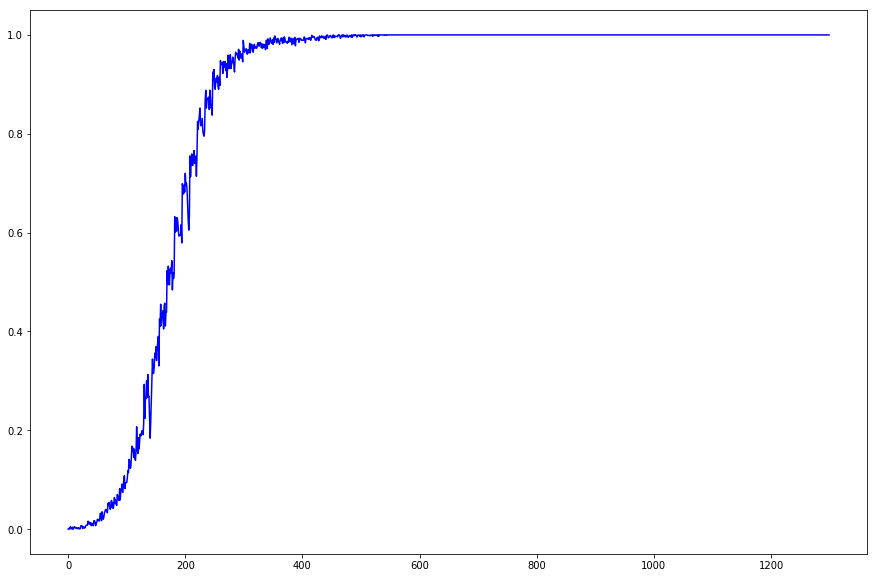

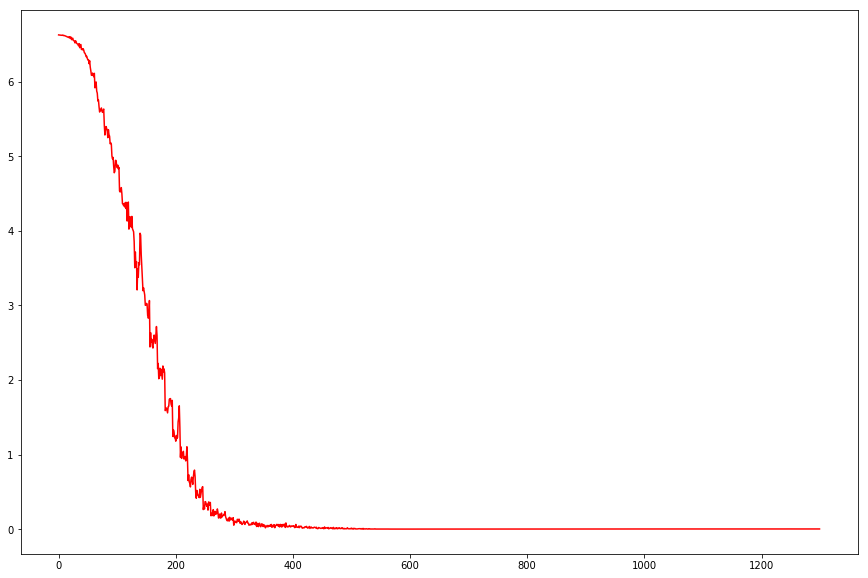

Time =  8176.721644639969


In [9]:
start_time = time.time()
trainModel(num_epochs=100, weight_decay=0.001, momentum=0.9, learning_rate=0.05, name="model1.ckpt")
print("Time = ", time.time() - start_time)

wd = 0.001 momentum = 0.9 lr =  0.01
Epoch [1/100], Step [4/13], Loss: 6.6215, Accuracy: 0.00200000%
Epoch [1/100], Step [8/13], Loss: 6.6209, Accuracy: 0.00200000%
Epoch [1/100], Step [12/13], Loss: 6.6189, Accuracy: 0.00100000%
Epoch [2/100], Step [4/13], Loss: 6.6173, Accuracy: 0.00300000%
Epoch [2/100], Step [8/13], Loss: 6.6159, Accuracy: 0.00300000%
Epoch [2/100], Step [12/13], Loss: 6.6164, Accuracy: 0.00800000%
Epoch [3/100], Step [4/13], Loss: 6.6134, Accuracy: 0.00900000%
Epoch [3/100], Step [8/13], Loss: 6.6097, Accuracy: 0.00400000%
Epoch [3/100], Step [12/13], Loss: 6.6069, Accuracy: 0.00300000%
Epoch [4/100], Step [4/13], Loss: 6.6054, Accuracy: 0.00300000%
Epoch [4/100], Step [8/13], Loss: 6.5976, Accuracy: 0.00700000%
Epoch [4/100], Step [12/13], Loss: 6.5930, Accuracy: 0.00500000%
Epoch [5/100], Step [4/13], Loss: 6.5891, Accuracy: 0.00600000%
Epoch [5/100], Step [8/13], Loss: 6.5811, Accuracy: 0.00100000%
Epoch [5/100], Step [12/13], Loss: 6.5762, Accuracy: 0.00700000

Epoch [42/100], Step [12/13], Loss: 1.4851, Accuracy: 0.62700000%
Epoch [43/100], Step [4/13], Loss: 1.2285, Accuracy: 0.67900000%
Epoch [43/100], Step [8/13], Loss: 1.2111, Accuracy: 0.69400000%
Epoch [43/100], Step [12/13], Loss: 1.1753, Accuracy: 0.71300000%
Epoch [44/100], Step [4/13], Loss: 0.9309, Accuracy: 0.77300000%
Epoch [44/100], Step [8/13], Loss: 1.0426, Accuracy: 0.74100000%
Epoch [44/100], Step [12/13], Loss: 1.0985, Accuracy: 0.72500000%
Epoch [45/100], Step [4/13], Loss: 0.7606, Accuracy: 0.82100000%
Epoch [45/100], Step [8/13], Loss: 0.7248, Accuracy: 0.80500000%
Epoch [45/100], Step [12/13], Loss: 0.9423, Accuracy: 0.75900000%
Epoch [46/100], Step [4/13], Loss: 0.6423, Accuracy: 0.84300000%
Epoch [46/100], Step [8/13], Loss: 0.6893, Accuracy: 0.81600000%
Epoch [46/100], Step [12/13], Loss: 0.7377, Accuracy: 0.81500000%
Epoch [47/100], Step [4/13], Loss: 0.6062, Accuracy: 0.83000000%
Epoch [47/100], Step [8/13], Loss: 0.5451, Accuracy: 0.85600000%
Epoch [47/100], Step

Epoch [84/100], Step [8/13], Loss: 0.0019, Accuracy: 1.00000000%
Epoch [84/100], Step [12/13], Loss: 0.0021, Accuracy: 1.00000000%
Epoch [85/100], Step [4/13], Loss: 0.0019, Accuracy: 1.00000000%
Epoch [85/100], Step [8/13], Loss: 0.0020, Accuracy: 1.00000000%
Epoch [85/100], Step [12/13], Loss: 0.0020, Accuracy: 1.00000000%
Epoch [86/100], Step [4/13], Loss: 0.0018, Accuracy: 1.00000000%
Epoch [86/100], Step [8/13], Loss: 0.0019, Accuracy: 1.00000000%
Epoch [86/100], Step [12/13], Loss: 0.0019, Accuracy: 1.00000000%
Epoch [87/100], Step [4/13], Loss: 0.0020, Accuracy: 1.00000000%
Epoch [87/100], Step [8/13], Loss: 0.0021, Accuracy: 1.00000000%
Epoch [87/100], Step [12/13], Loss: 0.0019, Accuracy: 1.00000000%
Epoch [88/100], Step [4/13], Loss: 0.0022, Accuracy: 1.00000000%
Epoch [88/100], Step [8/13], Loss: 0.0019, Accuracy: 1.00000000%
Epoch [88/100], Step [12/13], Loss: 0.0020, Accuracy: 1.00000000%
Epoch [89/100], Step [4/13], Loss: 0.0019, Accuracy: 1.00000000%
Epoch [89/100], Step

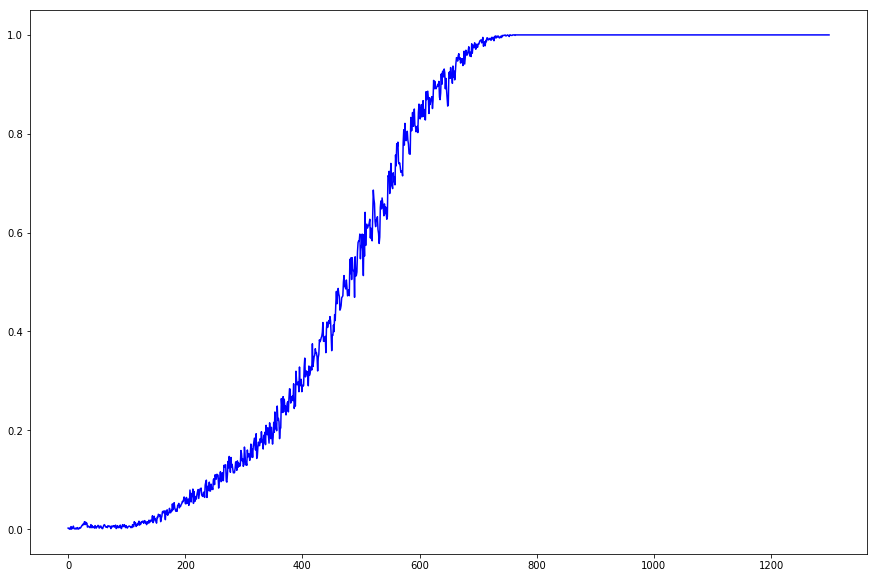

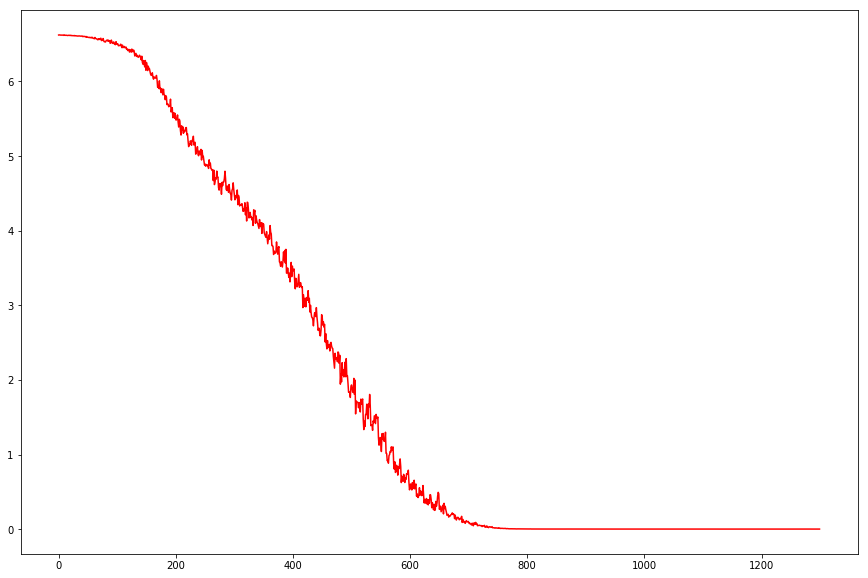

Time =  8169.595350027084


In [10]:
start_time = time.time()
trainModel(num_epochs=100, weight_decay=0.001, momentum=0.9, learning_rate=0.01, name="model2.ckpt")
print("Time = ", time.time() - start_time)

wd = 0.001 momentum = 0.9 lr =  0.001
Epoch [1/100], Step [4/13], Loss: 6.6228, Accuracy: 0.00300000%
Epoch [1/100], Step [8/13], Loss: 6.6238, Accuracy: 0.00100000%
Epoch [1/100], Step [12/13], Loss: 6.6207, Accuracy: 0.00000000%
Epoch [2/100], Step [4/13], Loss: 6.6226, Accuracy: 0.00000000%
Epoch [2/100], Step [8/13], Loss: 6.6220, Accuracy: 0.00300000%
Epoch [2/100], Step [12/13], Loss: 6.6243, Accuracy: 0.00100000%
Epoch [3/100], Step [4/13], Loss: 6.6233, Accuracy: 0.00000000%
Epoch [3/100], Step [8/13], Loss: 6.6224, Accuracy: 0.00400000%
Epoch [3/100], Step [12/13], Loss: 6.6223, Accuracy: 0.00100000%
Epoch [4/100], Step [4/13], Loss: 6.6222, Accuracy: 0.00000000%
Epoch [4/100], Step [8/13], Loss: 6.6214, Accuracy: 0.00000000%
Epoch [4/100], Step [12/13], Loss: 6.6220, Accuracy: 0.00000000%
Epoch [5/100], Step [4/13], Loss: 6.6229, Accuracy: 0.00100000%
Epoch [5/100], Step [8/13], Loss: 6.6219, Accuracy: 0.00000000%
Epoch [5/100], Step [12/13], Loss: 6.6213, Accuracy: 0.0030000

Epoch [42/100], Step [12/13], Loss: 6.6132, Accuracy: 0.00100000%
Epoch [43/100], Step [4/13], Loss: 6.6124, Accuracy: 0.00100000%
Epoch [43/100], Step [8/13], Loss: 6.6119, Accuracy: 0.00000000%
Epoch [43/100], Step [12/13], Loss: 6.6089, Accuracy: 0.00200000%
Epoch [44/100], Step [4/13], Loss: 6.6106, Accuracy: 0.00000000%
Epoch [44/100], Step [8/13], Loss: 6.6070, Accuracy: 0.00100000%
Epoch [44/100], Step [12/13], Loss: 6.6112, Accuracy: 0.00100000%
Epoch [45/100], Step [4/13], Loss: 6.6090, Accuracy: 0.00200000%
Epoch [45/100], Step [8/13], Loss: 6.6089, Accuracy: 0.00000000%
Epoch [45/100], Step [12/13], Loss: 6.6103, Accuracy: 0.00300000%
Epoch [46/100], Step [4/13], Loss: 6.6135, Accuracy: 0.00300000%
Epoch [46/100], Step [8/13], Loss: 6.6089, Accuracy: 0.00100000%
Epoch [46/100], Step [12/13], Loss: 6.6080, Accuracy: 0.00100000%
Epoch [47/100], Step [4/13], Loss: 6.6076, Accuracy: 0.00400000%
Epoch [47/100], Step [8/13], Loss: 6.6035, Accuracy: 0.00100000%
Epoch [47/100], Step

Epoch [84/100], Step [8/13], Loss: 6.5282, Accuracy: 0.00600000%
Epoch [84/100], Step [12/13], Loss: 6.5220, Accuracy: 0.00700000%
Epoch [85/100], Step [4/13], Loss: 6.5059, Accuracy: 0.00700000%
Epoch [85/100], Step [8/13], Loss: 6.4908, Accuracy: 0.01100000%
Epoch [85/100], Step [12/13], Loss: 6.5122, Accuracy: 0.01100000%
Epoch [86/100], Step [4/13], Loss: 6.5001, Accuracy: 0.00900000%
Epoch [86/100], Step [8/13], Loss: 6.4974, Accuracy: 0.01400000%
Epoch [86/100], Step [12/13], Loss: 6.4966, Accuracy: 0.01000000%
Epoch [87/100], Step [4/13], Loss: 6.4628, Accuracy: 0.00900000%
Epoch [87/100], Step [8/13], Loss: 6.4837, Accuracy: 0.01000000%
Epoch [87/100], Step [12/13], Loss: 6.4820, Accuracy: 0.00600000%
Epoch [88/100], Step [4/13], Loss: 6.4815, Accuracy: 0.01100000%
Epoch [88/100], Step [8/13], Loss: 6.4761, Accuracy: 0.01000000%
Epoch [88/100], Step [12/13], Loss: 6.4954, Accuracy: 0.01300000%
Epoch [89/100], Step [4/13], Loss: 6.5094, Accuracy: 0.00700000%
Epoch [89/100], Step

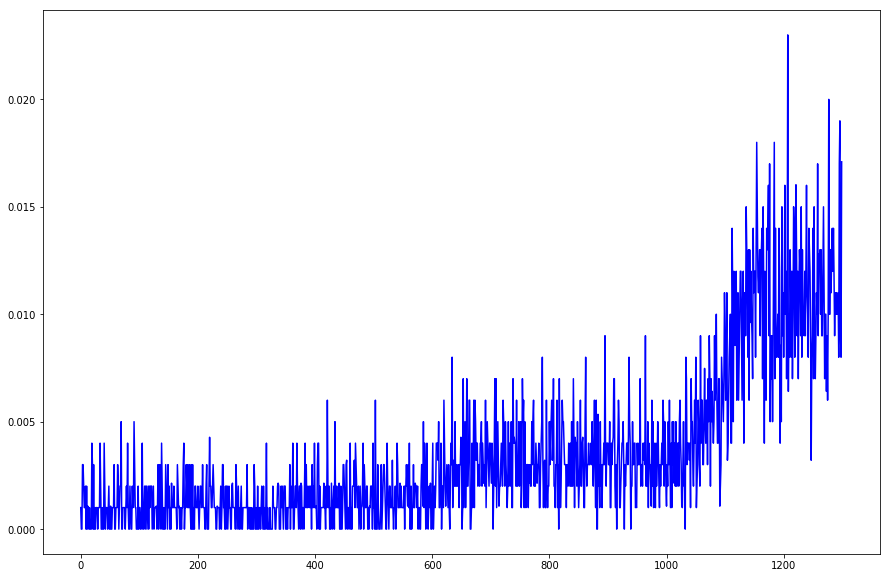

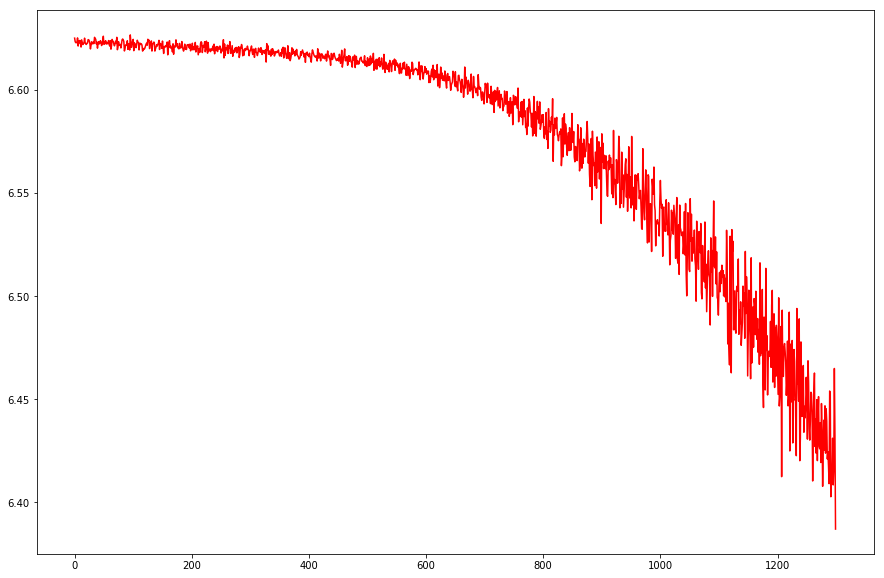

Time =  8112.0010488033295


In [11]:
start_time = time.time()
trainModel(num_epochs=100, weight_decay=0.001, momentum=0.9, learning_rate=0.001, name="model3.ckpt")
print("Time = ", time.time() - start_time)

wd = 0.001 momentum = 0.9 lr =  0.0001
Epoch [1/100], Step [4/13], Loss: 6.6252, Accuracy: 0.00000000%
Epoch [1/100], Step [8/13], Loss: 6.6215, Accuracy: 0.00100000%
Epoch [1/100], Step [12/13], Loss: 6.6232, Accuracy: 0.00300000%
Epoch [2/100], Step [4/13], Loss: 6.6219, Accuracy: 0.00200000%
Epoch [2/100], Step [8/13], Loss: 6.6227, Accuracy: 0.00000000%
Epoch [2/100], Step [12/13], Loss: 6.6258, Accuracy: 0.00100000%
Epoch [3/100], Step [4/13], Loss: 6.6194, Accuracy: 0.00300000%
Epoch [3/100], Step [8/13], Loss: 6.6219, Accuracy: 0.00100000%
Epoch [3/100], Step [12/13], Loss: 6.6230, Accuracy: 0.00100000%
Epoch [4/100], Step [4/13], Loss: 6.6218, Accuracy: 0.00100000%
Epoch [4/100], Step [8/13], Loss: 6.6206, Accuracy: 0.00100000%
Epoch [4/100], Step [12/13], Loss: 6.6237, Accuracy: 0.00200000%
Epoch [5/100], Step [4/13], Loss: 6.6238, Accuracy: 0.00100000%
Epoch [5/100], Step [8/13], Loss: 6.6238, Accuracy: 0.00100000%
Epoch [5/100], Step [12/13], Loss: 6.6234, Accuracy: 0.002000

Epoch [42/100], Step [12/13], Loss: 6.6220, Accuracy: 0.00200000%
Epoch [43/100], Step [4/13], Loss: 6.6220, Accuracy: 0.00300000%
Epoch [43/100], Step [8/13], Loss: 6.6217, Accuracy: 0.00200000%
Epoch [43/100], Step [12/13], Loss: 6.6241, Accuracy: 0.00100000%
Epoch [44/100], Step [4/13], Loss: 6.6237, Accuracy: 0.00200000%
Epoch [44/100], Step [8/13], Loss: 6.6194, Accuracy: 0.00700000%
Epoch [44/100], Step [12/13], Loss: 6.6184, Accuracy: 0.00000000%
Epoch [45/100], Step [4/13], Loss: 6.6222, Accuracy: 0.00500000%
Epoch [45/100], Step [8/13], Loss: 6.6230, Accuracy: 0.00300000%
Epoch [45/100], Step [12/13], Loss: 6.6206, Accuracy: 0.00400000%
Epoch [46/100], Step [4/13], Loss: 6.6217, Accuracy: 0.00500000%
Epoch [46/100], Step [8/13], Loss: 6.6234, Accuracy: 0.00300000%
Epoch [46/100], Step [12/13], Loss: 6.6239, Accuracy: 0.00200000%
Epoch [47/100], Step [4/13], Loss: 6.6182, Accuracy: 0.00500000%
Epoch [47/100], Step [8/13], Loss: 6.6219, Accuracy: 0.00400000%
Epoch [47/100], Step

Epoch [84/100], Step [8/13], Loss: 6.6193, Accuracy: 0.00300000%
Epoch [84/100], Step [12/13], Loss: 6.6195, Accuracy: 0.00400000%
Epoch [85/100], Step [4/13], Loss: 6.6155, Accuracy: 0.00300000%
Epoch [85/100], Step [8/13], Loss: 6.6182, Accuracy: 0.00200000%
Epoch [85/100], Step [12/13], Loss: 6.6172, Accuracy: 0.00200000%
Epoch [86/100], Step [4/13], Loss: 6.6188, Accuracy: 0.00700000%
Epoch [86/100], Step [8/13], Loss: 6.6199, Accuracy: 0.00600000%
Epoch [86/100], Step [12/13], Loss: 6.6173, Accuracy: 0.00200000%
Epoch [87/100], Step [4/13], Loss: 6.6192, Accuracy: 0.00000000%
Epoch [87/100], Step [8/13], Loss: 6.6211, Accuracy: 0.00300000%
Epoch [87/100], Step [12/13], Loss: 6.6172, Accuracy: 0.00300000%
Epoch [88/100], Step [4/13], Loss: 6.6168, Accuracy: 0.00700000%
Epoch [88/100], Step [8/13], Loss: 6.6210, Accuracy: 0.00400000%
Epoch [88/100], Step [12/13], Loss: 6.6203, Accuracy: 0.00400000%
Epoch [89/100], Step [4/13], Loss: 6.6189, Accuracy: 0.00500000%
Epoch [89/100], Step

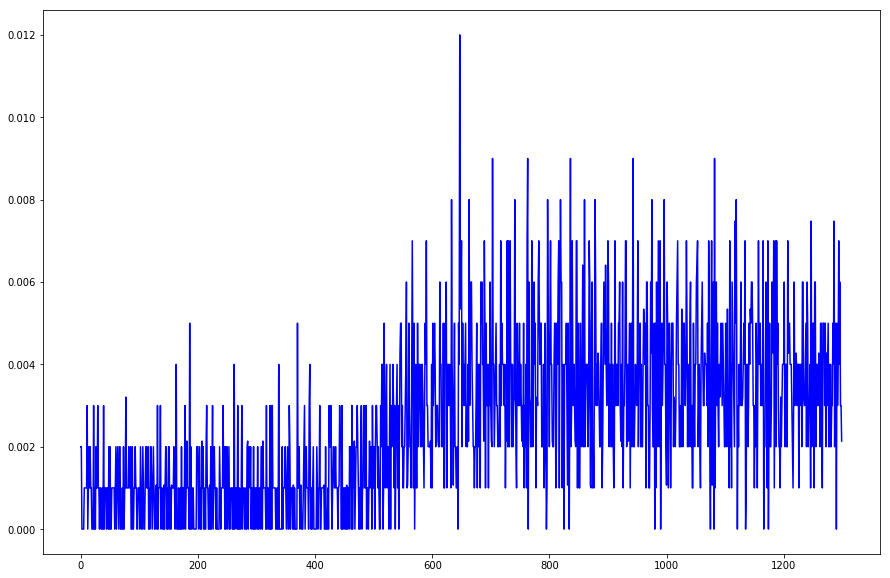

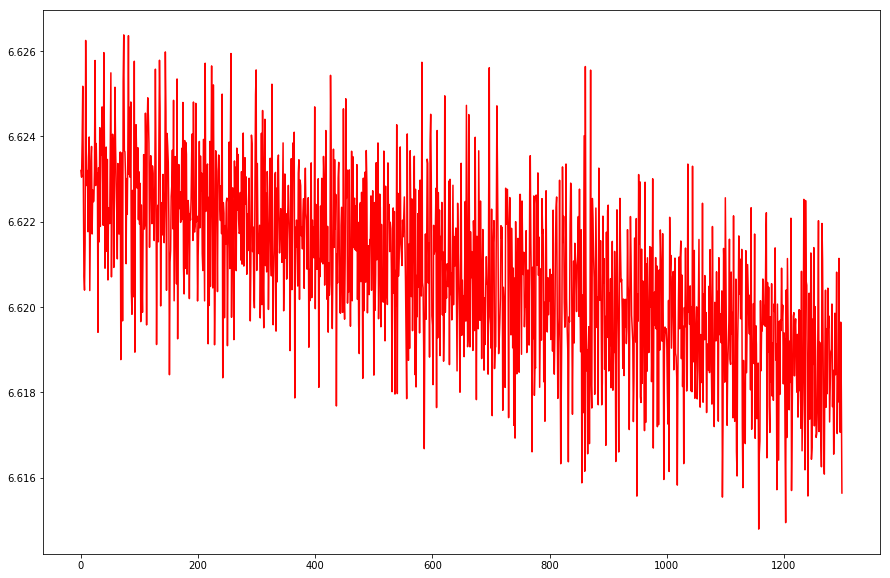

Time =  8081.970996141434


In [13]:
start_time = time.time()
trainModel(num_epochs=100, weight_decay=0.001, momentum=0.9, learning_rate=0.0001, name="model4.ckpt")
print("Time = ", time.time() - start_time)